In [1]:
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm

from util import *
from model.pinn import PINNs
from model.pinnsaddadd import PINNsformer

In [2]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [3]:
device = 'cuda:1'

In [4]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51) #获取训练数据，第一个参数是x的取值范围，第二个参数是t的取值范围，第三个和第四个参数分别是x和t的采样点数
#这样，res是一个形状为(51*51,2)的数组，其中每一行代表一个(x,t)点的坐标，代表配位点/训练数据。b_left、b_right、b_upper和b_lower分别是边界条件的训练点，这些点用于训练PINNsformer模型。
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101) #生成测试数据，采样点数为101x101
#这样，res_test是一个形状为(101*101,2)的数组，代表测试数据

#将数据转换为时间序列，输入的数据形状为(N, 2)，第一列x第二列t。最后返回的是一个伪时间序列数据，形状为(N, num_step, 2)，step则代表Δt，是伪时间序列的递增量。相当于把N个[x,t]转换为{[x,t],[x,t+Δt],[x,t+2Δt],...,[x,t+(num_step-1)Δt]}，即每个空间位置都有一个时间序列。
res = make_time_sequence(res, num_step=5, step=1e-4) #配位点的时间序列数据，res形状变为(51*51, 5, 2)，即每个(x,t)点都有5个时间步的序列数据
b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #左边界条件的时间序列数据，b_left形状变为(51, 5, 2)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #右边界条件的时间序列数据，b_right形状变为(51, 5, 2)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #上边界条件的时间序列数据，b_upper形状变为(51, 5, 2)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #下边界条件的时间序列数据，b_lower形状变为(51, 5, 2)

#将数据转移到显卡上
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

#将数据分离为x和t的部分
x_res, t_res = res[:,:,0:1], res[:,:,1:2] #将res的第一列作为x，第二列作为t,这样x_res和t_res的形状都是(51*51, 5, 1)，即51*51个时间序列，每个(x,t)点都有5个时间步的序列数据
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2] #将b_left的第一列作为x，第二列作为t,这样x_left和t_left的形状都是(51, 5, 1)，即每个左边界点都有5个时间步的序列数据
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2] #将b_right的第一列作为x，第二列作为t,这样x_right和t_right的形状都是(51, 5, 1)，即每个右边界点都有5个时间步的序列数据
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2] #将b_upper的第一列作为x，第二列作为t,这样x_upper和t_upper的形状都是(51, 5, 1)，即每个上边界点都有5个时间步的序列数据
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2] #将b_lower的第一列作为x，第二列作为t,这样x_lower和t_lower的形状都是(51, 5, 1)，即每个下边界点都有5个时间步的序列数据

#初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
def init_weights(m):
    if isinstance(m, nn.Linear): #判断是否是线性层
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子

L1error = []
L2error = []

for seed in seeds:
    set_seed(seed) #设置随机数种子

    model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device) #创建PINNsformer模型，模型输出维度为1，outputlayer模块的隐藏层维度为512，数据的特征嵌入维度为32，编码器和解码器的层数为1，注意力机制的头数为2

    model.apply(init_weights) #初始化模型中线性层的权重和偏置
    optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

    loss_track = [] #记录loss

    for i in tqdm(range(500)): #训练500次
        def closure():
            pred_res = model(x_res, t_res) #得到配位点的预测结果
            pred_left = model(x_left, t_left) #得到左边界点的预测结果
            pred_right = model(x_right, t_right) #得到右边界点的预测结果
            pred_upper = model(x_upper, t_upper) #得到上边界点的预测结果
            pred_lower = model(x_lower, t_lower) #得到下边界点的预测结果

            #计算配位点的时间导数u_t和空间导数u_x
            u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

            #计算损失，共三项损失
            loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
            loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

            loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

            loss = loss_res + loss_bc + loss_ic
            optim.zero_grad()
            loss.backward()
            return loss

        optim.step(closure)

    # Visualize PINNsformer
    res_test = make_time_sequence(res_test, num_step=5, step=1e-4)  #将测试数据转换为时间序列，形状变为(101*101, 5, 2)，即每个(x,t)点都有5个时间步的序列数据
    res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device) #将测试数据转换为张量，并设置requires_grad=True以便计算梯度
    x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2] #将测试数据分离为x和t的部分，x_test和t_test的形状都是(101*101, 5, 1)，即每个(x,t)点都有5个时间步的序列数据

    with torch.no_grad(): #在不需要计算梯度的情况下进行预测
        pred = model(x_test, t_test)[:,0:1] #只取预测结果的第一列，即时间步为0的预测结果，pred的形状为(点的数量，序列长度，d_out=1)，现在只取序列的第一个，变为(点的数量，d_out=1)
        pred = pred.cpu().detach().numpy()

    pred = pred.reshape(101,101)

    def h(x):
        return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

    def u_ana(x,t):
        return h(x) * np.exp(5*t) / ( h(x) * np.exp(5*t) + 1 - h(x))

    res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)
    u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

    rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
    rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

    print('relative L1 error: {:4f}'.format(rl1))
    print('relative L2 error: {:4f}'.format(rl2))

    L1error.append(rl1)
    L2error.append(rl2)

mean Error u: 3.036806e-01
Variance Error u: 1.961987e-01


/tmp/ipykernel_3904694/3836312666.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


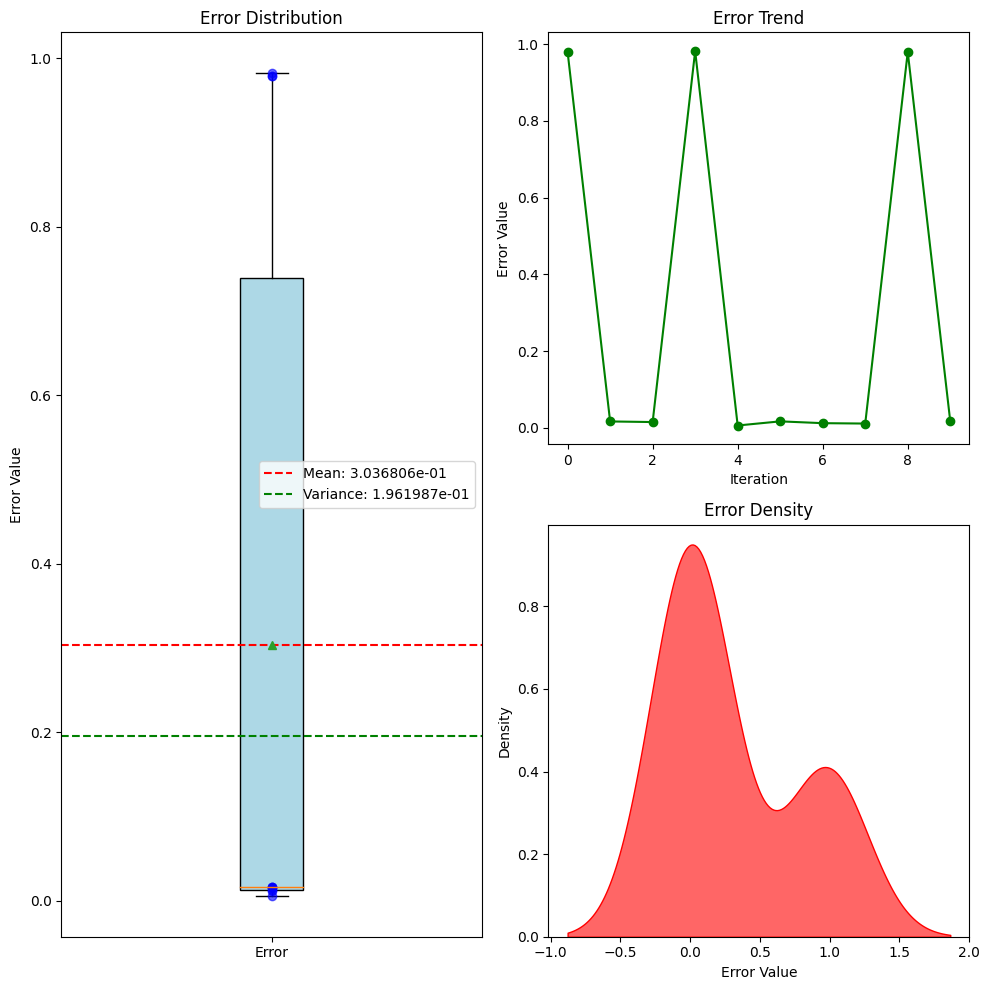

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = L1error

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [7]:
print('L1 error:', L1error)
print('L2 error:', L2error)

L1 error: [0.9794545957234543, 0.01684902603442148, 0.015258414736440795, 0.9819036936292518, 0.006272874707806479, 0.017038570036405704, 0.012356138545061445, 0.011331169791124944, 0.9794524031619452, 0.016889364289565355]
L2 error: [0.9788461451543574, 0.03277755822101678, 0.030371578268099917, 0.9813598006034121, 0.012778955062850636, 0.03407734638054968, 0.024997580726560976, 0.02425579670363394, 0.9785340846858819, 0.03409499470944081]
